In [1]:
import data
import tensorflow as tf
import train

Data Loading and Processing

In [2]:
handlr = data.Train_Data('D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/',['train_spider.json','train_others.json'])
input_text_processor = data.Features().vectorizor(handlr.questions , data.Max_Vocab_Size)
output_text_processor = data.Features().vectorizor(handlr.sql , data.Max_Vocab_Size)

Reading file at path D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/train_spider.json
7000 Rows in Total
Reading file at path D:/DS/Learnin/Essex MS/CE888/git/CE888/assignment2/seq2seq/spider/train_others.json
8659 Rows in Total
Filter Easy Queries
Splittin the Train and Test data
(727, 7)
Data for Training (2908, 7)
Data for Testing (727, 7)
Sample Vocabulary ['', '[UNK]', 'the', '[start]', '[end]', 'of', '?', '.', 'what', 'are']
Sample Vocabulary ['', '[UNK]', 'select', 'from', '[start]', '[end]', 'where', ')', '(', '=']


Getting the List of Questions in inp and List of Queries as target

In [3]:
inp = handlr.questions
targ = handlr.sql

In [4]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = data.BATCH_SIZE

Create Batches of Training Data

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [33]:
embedding_dim = 100
units = data.units

Download Glove Embedding and create Matrix

In [34]:
import numpy as np

embeddings_dictionary = dict()

emb = 'D:/DS/Learnin/Essex MS/CE888/embeddings/glove.6B.100d.txt'
glove_file = open(emb, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

Create Embedding Matrix from the Vocabulary of the input senetences

In [35]:
max_input_vocab_size = input_text_processor.vocabulary_size()
num_words = max_input_vocab_size
EMBEDDING_SIZE = embedding_dim
embedding_matrix = np.zeros((num_words, EMBEDDING_SIZE))
for index,word in enumerate(input_text_processor.get_vocabulary()):
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
train.embedding_matrix = embedding_matrix

Compile the Model

In [56]:
train_translator = train.TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function = True)

# Configure the loss and optimizer
train_translator.compile(
    optimizer = tf.optimizers.Adam(),
    loss = train.MaskedLoss(),
)

Model Callbacks

In [58]:
batch_loss = train.BatchLogs('batch_loss')
run_logdir = train.get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

Fit the Model

history = train_translator.fit(dataset, epochs=50, callbacks=[batch_loss,tensorboard_cb])

Plot Graph for Batch Loss

Text(0, 0.5, 'Batch Loss')

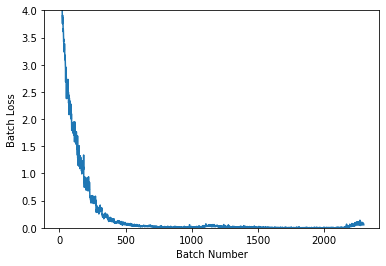

In [60]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6), dpi=200)
plt.plot(batch_loss.logs)
plt.ylim([0, 4])
plt.xlabel('Batch Number')
plt.ylabel('Batch Loss')


Translation Model

In [63]:
translator = train.Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

Test the model on Sample Input

In [72]:
%%time
input_text = tf.constant([
    'How many singers do we have?', # "It's really cold here."
    'What is the total number of singers?', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

select count ( * ) from flight
select count ( * ) from settlement_amount where police_officers > 0

Wall time: 227 ms


Test the model on Test Dataset

In [76]:
test = list(handlr.df_test['question'].values)

input_text = tf.constant(test)

result = translator.translate(input_text = input_text)

In [74]:
query = handlr.df_test['query'].values

Print Accuracy for Exact Match

In [75]:
train.exact_match_accuracy(query,result)

Accuracy is 28.89 %
